In [34]:
import pandas as pd
import cv2
import os
from util import listdir_nohidden
import numpy as np

squares_dir = "../../data/squares/all/"
train_dir = "../../data/squares/training/"
valid_dir = "../../data/squares/validation/"

def count_examples(path):
    sum = 0
    for d in listdir_nohidden(path):
        sum += len(listdir_nohidden(os.path.join(path, d)))
    return sum


In [35]:
# 1) load all squares into a matrix X

size = 32

def load_images(path):
    N = count_examples(path)
    X = np.zeros((N, size**2))
    y = np.zeros((N, 1))

    i = 0
    labels = {"_b": 0, "_k": 1, "_n": 2, "_p": 3, "_q": 4, "_r": 5, "B": 6, "f": 7, "K": 8, "N": 9, "P": 10, "Q": 11, "R": 12}

    image_folders = listdir_nohidden(path)

    for folder in image_folders:
        imgs = listdir_nohidden(os.path.join(path, folder))
        label = labels[folder]
        for filename in imgs:
            img = cv2.imread(os.path.join(squares_dir, folder, filename), 0)
            img = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)
            img = img.reshape((1, size**2))
            X[i,:] = img
            y[i] = label
            i += 1

    X /= 255.
    return X, y

X, y = load_images(train_dir)

print(X.shape)
print(y.shape)

(5636, 1024)
(5636, 1)


In [36]:
# 2) convert to pandas dataframe

feat_cols = ["pixel"+str(i) for i in range(X.shape[1])]

df = pd.DataFrame(X, columns=feat_cols)
df['label'] = y
df['label'] = df['label'].apply(lambda i: str(i))

X, y = None, None

print("Size of the dataframe: {}".format(df.shape))

Size of the dataframe: (5636, 1025)


In [37]:
# random vector
rndperm = np.random.permutation(df.shape[0])

<Figure size 432x288 with 0 Axes>

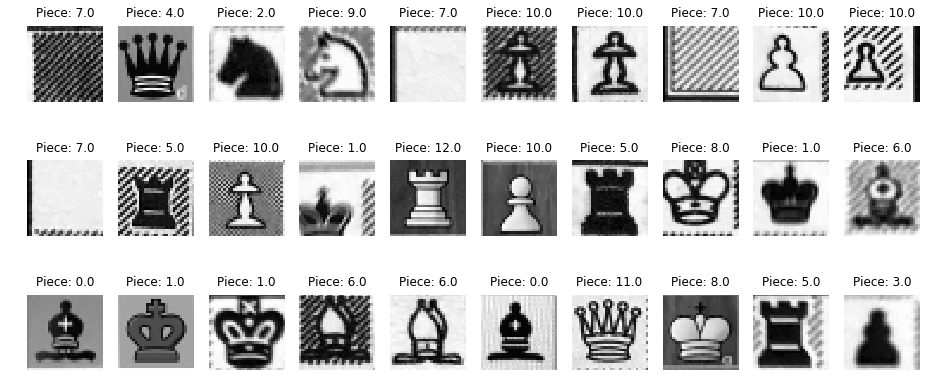

In [38]:
import matplotlib.pyplot as plt

# Plot some examples
plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,30):
    ax = fig.add_subplot(3,10,i+1, title='Piece: ' + str(df.loc[rndperm[i],'label']))
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((size,size)).astype(float))
    ax.axis("off")
plt.show()

In [39]:
# 3) Apply PCA with 50 components

from sklearn.decomposition import PCA

pca = PCA(n_components=40)
pca_result = pca.fit_transform(df[feat_cols].values)

print("Cumulative explained variation for 50 principal components: {}".format(np.sum(pca.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.7752583010388063


In [40]:
# 4) Apply t-SNE to the PCA results

import time
from sklearn.manifold import TSNE

n_sne = df.shape[0]

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result[rndperm[:n_sne], :])

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5636 samples in 0.009s...
[t-SNE] Computed neighbors for 5636 samples in 1.651s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5636
[t-SNE] Computed conditional probabilities for sample 2000 / 5636
[t-SNE] Computed conditional probabilities for sample 3000 / 5636
[t-SNE] Computed conditional probabilities for sample 4000 / 5636
[t-SNE] Computed conditional probabilities for sample 5000 / 5636
[t-SNE] Computed conditional probabilities for sample 5636 / 5636
[t-SNE] Mean sigma: 1.792923
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.296562
[t-SNE] Error after 300 iterations: 2.309311
t-SNE done! Time elapsed: 56.1184458732605 seconds


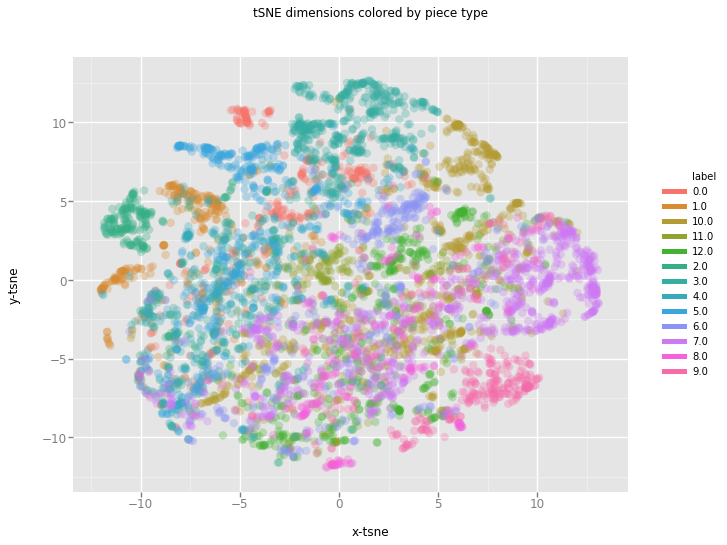

<ggplot: (7034896157)>

In [42]:
# 5) Plot the results
from ggplot import ggplot, aes, geom_point, ggtitle

df_tsne = df.loc[rndperm[:n_sne],:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

chart = ggplot(df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=70,alpha=0.3) \
        + ggtitle("tSNE dimensions colored by piece type")
chart


## Train SVM classifier on PCA-reduced data

In [47]:
from sklearn import svm
from sklearn.metrics import accuracy_score

clf = svm.SVC()
y = df["label"]
clf.fit(pca_result, y)
yhat = clf.predict(pca_result)
acc = accuracy_score(yhat, y)

print(acc)
# Gets 92% accuracy on training data

(5636, 40)
(5636,)
0.9205110007097232


In [54]:
X_val, y_val = load_images(valid_dir)

X_val_pca = pca.fit_transform(X_val)

ytilde = clf.predict(X_val_pca)

y_val = y_val.astype(str)

acc = accuracy_score(ytilde, y_val)

print(acc)
# Gets 36% accuracy on test data

0.3615819209039548
